# Predicting Elections with "Mister P" (MRP, multi-level regression and post-stratification)

## Andrew Enfield, University of Washington Data 512 Autumn 2017

# Introduction

In this project I used Bayesian multi-level regression and post-stratification (MRP), and Python and [PyMC3](https://github.com/pymc-devs/pymc3) to adjust an unrepresentative sample of election preferences and predict the outcome of the 2016 US Presidential election. My results don't match the survey from which I used the raw data, possibly because I haven't used enough predictors (in the interest of simplicity). Nonetheless, the code and explanation show an attempt at learning and applying MRP using a language and MCMC framework that I haven't found used for such a purpose before. 

**NOTE:** I'm new to this concept and PyMC3, and did this work without review. I also spent a relatively minimal amount of time on this project, as it was just a portion of the work for a particular class. If you happen upon this project and see things I did incorrectly or can do better, please let me know - it'll help me continue to learn. There's a list of many things that I could do to improve this work in the Discussion section at the end of the paper.

# Background and related work

Most statistics assume implicitly or explicitly that the sample on which the statistic or inference is applied is _representative_ of the population of interest. I've found personally at least that this assumption is often violated: to a first approximation, I'm more likely to be correct when I assume that a sample is _not representative_.

An unrepresentative sample can cause the results based on the sample to be incorrect, and can have other bad effects, including missing signal from under-represented groups (for example, people that are harder to find in order to sample). The degree to which this is a problem in practice depends, at least, on the degree to which the sample is not representative and on the importance of the inference made based on the sample.

While a properly-run randomized controlled trial (RCT) can guarantee a representative sample, it's not always practical to run such an experiment. Furthermore, requiring an RCT automatically excludes numerous convenience or other samples. This is especially unfortunate given the explosion in recent years of accessible data that likely contains information but that isn't known to be representative of a larger population.

It is possible to adjust unrepresentative data after the fact and generate results that more closely hew to the results that would have been obtained from a representative sample. While this isn't a silver bullet, and can be difficult, when done successfully it can make results more useful. The New York Times article [How One 19-Year-Old Illinois Man Is Distorting National Polling Averages](https://www.nytimes.com/2016/10/13/upshot/how-one-19-year-old-illinois-man-is-distorting-national-polling-averages.html) describes general issues with unrepresentative samples as well as with adjusting these samples.

In more detail, two of multiple methods that can be used to adjust samples are [propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching) and [post-stratification](https://onlinecourses.science.psu.edu/stat506/node/29). I use post-stratification in this work.

Generally, post-stratification involves three steps:

1. Dividing the population into "cells", one for each combination of values in the variables of interest. For example, in this notebook I know the sex, race/ethnicity, and state for each respondent. The Pew Research Center source data (documented in the [README](README.md)) has two values for sex, five values for race/ethnicity, and 51 values for state (including the District of Columbia). This makes for 2 x 5 x 51 = 510 combinations of values, or cells. 

2. For each cell, estimating the statistic in question for observations with the characteristics for that cell and finding the proportion of the overall population in that cell. I estimate the probability of people with the particular combination of sex, race/ethnicity, and state expressing a preference for Trump, with the complement of that probability being the preference for Clinton, using the Pew Research Center poll data. I obtain the proportion of the US population for each cell from the US Census Bureau's Current Population Survey (CPS). Then, the contribution of that cell to the overall statistic is calculated by multiplying the estimated statistic and the population.

3. Calculate the final estimate as an average of all cells, weighted by the population in each cell. 

In this project I use a particular approach called "multi-level regression and post-stratification" (MRP), which is distinguished by its use of Bayesian multi-level (or hierarchical) regression. As related to the previous steps, this is the particular implementation of the "estimate the statistic in question" part of step two above. Bayesian regression uses models where the regression coefficients are defined as parameters to be estimated based on the observed data as well as pre-chosen distributions - here, I use primarily normal distributions - using Bayes' Rule. The "multi-level" part of the implementation refers to the use of additional parameters that are also estimated and that are "above" or shared by multiple lower-level parameters. The model below, for example, defines a regression coefficient/parameter for each state, as well as a higher level "hyper" parameter that is shared by all states. The value of this higher level parameter depends on the values of all of the lower level parameters, generally in proportion to the amount of data associated with each lower level parameter. As a result, parameters associated with smaller amounts of data are automatically - by Bayes' Rule - "shrunk" toward the mean value, while parameters associated with more data are defined primarily by the data itself.

Note also that while Bayesian multi-level regression has advantages, any approach - including simple OLS logistic regression - could be used to find the estimate. 

MRP has been implemented and popularized by academics including Andrew Gelman, and others, including via the following papers and blog posts (this is a non-exhaustive list):
- [Forecasting elections with non-representative polls](http://www.stat.columbia.edu/~gelman/research/published/forecasting-with-nonrepresentative-polls.pdf); Wang, Rothschild, Goel, Gelman.
- [Deep Interactions with MRP: Election Turnout and Voting Patterns Among Small Electoral Subgroups](http://www.stat.columbia.edu/~gelman/research/published/misterp.pdf); Ghitza, Gelman.
- [Estimating State Public Opinion With Multi-Level Regression and Poststratification using R](http://www.princeton.edu/~jkastell/MRP_primer/mrp_primer.pdf); Kastellec, Lax, Phillips.
- [We Gave Four Good Pollsters the Same Raw Data. They Had Four Different Results.](https://www.nytimes.com/interactive/2016/09/20/upshot/the-error-the-polling-world-rarely-talks-about.html); Cohn.
- [Mister P can solve problems with survey weighting](http://andrewgelman.com/2016/10/12/31398/); Gelman.
- [Mister P: What’s its secret sauce?](http://andrewgelman.com/2013/10/09/mister-p-whats-its-secret-sauce/); Gelman.

There are a variety of libraries and packages for doing Bayesian inference and analysis, in this work I use [PyMC3](https://github.com/pymc-devs/pymc3), which is a "Python package for Bayesian statistical modeling and Probabilistic Machine Learning which focuses on advanced Markov chain Monte Carlo and variational fitting algorithms."




# Methods

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm

# to generate the full matrix of input data from a list of possibilities
import itertools 

# to sanity check some pymc3 results against normal logistic regression results
from sklearn.linear_model import LogisticRegression 

In [2]:
# to enable viewing longer Series and DataFrame instances
pd.set_option('display.max_rows', 500)

## Load and prepare Pew poll data with candidate preferences

The poll data is from the Pew Research Center and is documented in more detail in the [README](README.md). This data contains demographic information and the candidate each person prefers. Here I load a subset of the full data set with just the fields we need to do MRP.

In [3]:
d = pd.read_csv('pew_poll.csv')
d.shape

(2583, 6)

In [4]:
d[:2]

,state,sex,q10horseGP,race3m1,race3m2,weight
0,Minnesota,Male,Trump/lean Trump,"White (e.g., Caucasian, European, Irish, Itali...",NaN,2.088235
1,Delaware,Female,Clinton/lean Clinton,"White (e.g., Caucasian, European, Irish, Itali...",NaN,1.264706


The readme.txt file that comes with the Pew Research Center data explains how to convert the data's race3m1 and race3m2 fields into a 'racecmb' field. The next bit of code implements the text as Python code, to generate a racecmb field in the data.

In [5]:
racethn_to_index = {
    "White (e.g., Caucasian, European, Irish, Italian, Arab, Middle Eastern)": 1,
    "Black or African-American (e.g., Negro, Kenyan, Nigerian, Haitian)": 2,
    "Asian or Asian-American (e.g., Asian Indian, Chinese, Filipino, Vietnamese or other Asian origin groups)": 3,
    "Some other race (SPECIFY____ IF NEEDED: What race or races is that?)": 4,
    "Native American/American Indian/Alaska Native (VOL.)": 5,
    "Pacific Islander/Native Hawaiian (VOL.)": 6,
    "Hispanic/Latino (VOL.) (e.g., Mexican, Puerto Rican, Cuban)": 7,
    "Don't know (VOL.)": 8,
    "Refused (e.g., non-race answers like American, Human, purple) (VOL.)": 9
}

d['race3m1_index'] = d['race3m1'].map(racethn_to_index)
d['race3m2_index'] = d['race3m2'].map(racethn_to_index)

In [6]:
def get_racecmb(row):
    if ((row['race3m2_index'] > 0) & (row['race3m2_index'] < 8)):
        return 'Mixed Race'
    elif (row['race3m1_index'] == 1):
        return 'White'
    elif (row['race3m1_index'] == 2):
        return 'Black or African-American'
    elif (row['race3m1_index'] == 3):
        return 'Asian or Asian-American'
    elif (row['race3m1_index'] >= 4 & row['race3m1_index'] <= 7):
        return 'Or some other race'
    elif ((row['race3m1_index'] >= 8) & (row['race3m1_index'] <= 9)):
        return 'Dont know/Refused (VOL.)'

In [7]:
d['racecmb'] = d.apply(get_racecmb, axis=1)

In [8]:
d['racecmb'].value_counts(dropna=False)

White                        1935
Black or African-American     258
Or some other race            230
Asian or Asian-American        83
Mixed Race                     77
Name: racecmb, dtype: int64

The q10horseGP field contains the preference of the person.

In [9]:
d['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton     972
Trump/lean Trump         858
Not registered           466
Johnson/lean Johnson     124
DK-refused to lean        76
Stein/lean Stein          57
Other-refused to lean     30
Name: q10horseGP, dtype: int64

I'm only modeling a binary outcome, so I'll filter to just the rows with people that express a preference for Clinton or Trump. (See the Discussion section below for more about how I could improve the handling of people with non-Clinton and non-Trump in this analysis.)

In [10]:
d_only = d[(d['q10horseGP'] == 'Clinton/lean Clinton') | 
           (d['q10horseGP'] == 'Trump/lean Trump')]
d_only.shape

(1830, 9)

In [11]:
d_only['q10horseGP'].value_counts(dropna=False)

Clinton/lean Clinton    972
Trump/lean Trump        858
Name: q10horseGP, dtype: int64

As the next few lines show, we only have 50 states in the data, even though we'd expect 51, including D.C.

In [12]:
len(d_only['state'].unique())

50

In [13]:
d_only['state'].value_counts(dropna=False)

California              158
Texas                   133
Florida                 123
New York                121
Pennsylvania             75
Ohio                     72
New Jersey               68
Georgia                  62
North Carolina           61
Michigan                 61
Virginia                 60
Illinois                 57
Minnesota                48
Washington               45
Arizona                  45
Wisconsin                43
Tennessee                37
Kentucky                 34
Missouri                 34
Colorado                 33
South Carolina           33
Indiana                  33
Maryland                 30
Oregon                   29
Massachusetts            28
Louisiana                28
Oklahoma                 26
Alabama                  22
Iowa                     19
Kansas                   19
Nevada                   18
Idaho                    18
Connecticut              17
West Virginia            15
Utah                     15
Mississippi         

There are no observations from South Dakota in the data. (There was a row before I filtered to just people with Clinton/Trump preferences.)

In [14]:
d_only[d_only['state'] == 'South Dakota']

,state,sex,q10horseGP,race3m1,race3m2,weight,race3m1_index,race3m2_index,racecmb


Since we don't have any rows in our two-party data with South Dakota, absent any extra work on our part, we won't have an indicator variable for SD, which'll make it harder to do things with the state later, including to get state-level probabilities. 

The following code creates a dataframe with a row per respondent, with indicator variables for each state, including South Dakota (which I add manually, and which is always zero). The models use these indicator fields as part of estimating the probability of voting for Trump.

In [15]:
# add South Dakota, using the same index to make sure we don't extra cols (there may be a better way to do this)
state_dummies = pd.concat([pd.get_dummies(d_only['state']), 
                           pd.Series(name='South Dakota', data=np.repeat(0, len(d_only)), index=d_only.index)], axis=1)
# alphabetize to put SD in the right spot
state_dummies = state_dummies.reindex(sorted(state_dummies.columns), axis=1)
state_dummies.shape

(1830, 51)

In [16]:
state_count = len(state_dummies.columns.values)
state_count

51

Create a dict that maps the state's number - which I see in, for example, the coefficients generated by the models below - to the state's name. I use this dict below to generate the complete set of cells, for prediction/post-stratification. It's also useful to do focused research on particular IDs, since it shows the particular state for each ID in question.

In [17]:
state_number_to_name = dict(list(zip(range(0,51), sorted(state_dummies.columns.values))))
state_number_to_name

{0: 'Alabama',
 1: 'Alaska',
 2: 'Arizona',
 3: 'Arkansas',
 4: 'California',
 5: 'Colorado',
 6: 'Connecticut',
 7: 'Delaware',
 8: 'District of Columbia',
 9: 'Florida',
 10: 'Georgia',
 11: 'Hawaii',
 12: 'Idaho',
 13: 'Illinois',
 14: 'Indiana',
 15: 'Iowa',
 16: 'Kansas',
 17: 'Kentucky',
 18: 'Louisiana',
 19: 'Maine',
 20: 'Maryland',
 21: 'Massachusetts',
 22: 'Michigan',
 23: 'Minnesota',
 24: 'Mississippi',
 25: 'Missouri',
 26: 'Montana',
 27: 'Nebraska',
 28: 'Nevada',
 29: 'New Hampshire',
 30: 'New Jersey',
 31: 'New Mexico',
 32: 'New York',
 33: 'North Carolina',
 34: 'North Dakota',
 35: 'Ohio',
 36: 'Oklahoma',
 37: 'Oregon',
 38: 'Pennsylvania',
 39: 'Rhode Island',
 40: 'South Carolina',
 41: 'South Dakota',
 42: 'Tennessee',
 43: 'Texas',
 44: 'Utah',
 45: 'Vermont',
 46: 'Virginia',
 47: 'Washington',
 48: 'West Virginia',
 49: 'Wisconsin',
 50: 'Wyoming'}

Now I'll create a single dataframe with indicator variables for each field. I need this for all categorical variables, which are all the variables - sex, race, state - that exist in this analysis. 

Sex has a single indicator variable, called 'Male', while race and state have an indicator variable per value. That is, a value of 0 for 'Male' indicates female while a 1 indicates male. Each individual race and state value has its own indicator field.

In [18]:
d_only_dummies = pd.concat([pd.get_dummies(d_only['sex'], drop_first=True),
                            pd.get_dummies(d_only['racecmb']),
                            state_dummies], axis=1)
d_only_dummies.shape

(1830, 57)

In [19]:
d_only_dummies[:2]

,Male,Asian or Asian-American,Black or African-American,Mixed Race,Or some other race,White,Alabama,Alaska,Arizona,Arkansas,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
0,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Generate data frames of all cells (indicator and otherwise), for use as input data

Ultimately I want a prediction - the probability of voting for Trump and Clinton - for each cell: for each combination of values in the features on which I'm stratifying. I'll create two data frames here, each with one row per cell: one with the values themselves, and one with indicator/dummy variables (for use when predicting).

In [20]:
all_cells_list = list(itertools.product(np.sort(d_only['sex'].unique()), 
                                        np.sort(d_only['racecmb'].unique()),
                                        sorted(state_number_to_name.values())))
all_cells_list[:2]

[('Female', 'Asian or Asian-American', 'Alabama'),
 ('Female', 'Asian or Asian-American', 'Alaska')]

In [21]:
len(all_cells_list)

510

In [22]:
all_cells = pd.DataFrame(all_cells_list, columns=['sex','racecmb','state'])
all_cells[:2]

,sex,racecmb,state
0,Female,Asian or Asian-American,Alabama
1,Female,Asian or Asian-American,Alaska


In [23]:
# remove sex_Female since we only need one col for sex
all_cells_dummies = pd.get_dummies(all_cells).drop('sex_Female', 1)
all_cells_dummies[:3]

,sex_Male,racecmb_Asian or Asian-American,racecmb_Black or African-American,racecmb_Mixed Race,racecmb_Or some other race,racecmb_White,state_Alabama,state_Alaska,state_Arizona,state_Arkansas,...,state_South Dakota,state_Tennessee,state_Texas,state_Utah,state_Vermont,state_Virginia,state_Washington,state_West Virginia,state_Wisconsin,state_Wyoming
0,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


## Estimate voter preferences using multi-level regression and PyMC3

Now I'm ready to define a multi-level/hierarchical model to estimate plausible values, given the data, for parameters I define in the model. Specifically, I'll define the model as a multiple logistic regression model so that I can estimate plausible coefficients for sex, each race/ethnicity value, and each state. Then I'll use PyMC3 to generate an MCMC chain, and extract the mean and credible intervals for the coefficients.

I want a vector with the observed data, which is the preference for Clinton (0) and Trump (1).

In [24]:
y_obs_categorical = pd.Categorical(d_only['q10horseGP'])
y_obs = y_obs_categorical.codes

sum(y_obs == 0), sum(y_obs == 1)

(972, 858)

In [25]:
y_obs_categorical

[Trump/lean Trump, Clinton/lean Clinton, Trump/lean Trump, Trump/lean Trump, Clinton/lean Clinton, ..., Trump/lean Trump, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton, Clinton/lean Clinton]
Length: 1830
Categories (2, object): [Clinton/lean Clinton, Trump/lean Trump]

And I'll give names to the specific columns I care about when training the model, for clarity.

In [26]:
vals_sex = d_only_dummies.values[:,0]
vals_racecmb = d_only_dummies.values[:,1:6]
vals_state = d_only_dummies.values[:,6:]

vals_sex.shape, vals_racecmb.shape, vals_state.shape

((1830,), (1830, 5), (1830, 51))

And define the logistic function so that I can extract probabilities from the results of the linear model, while the I'm generating the chain, below.

In [27]:
def standard_logistic(x):
    return 1 / (1 + np.exp(-x))

Teaching Bayesian inference and MCMC is outside the scope of this paper, but I will try to summarize the model briefly. I'll also say that there's nothing particularly special about this mode: it's a relatively standard hierarchical/multi-level Bayesian logistic regression model.

The next block of code defines the model using PyMC3. From a high-level perspective, the code just defines a multiple logistic regression model: the model includes a 'mu' parameter that is just the result of a very standard linear equation, with an alpha/intercept, and with a coefficient for each indicator variable (in this example, one of 57 variables: one for sex, five for race/ethnicity, and 51 for state). These coefficients are named beta_sex, beta_race (an array of size five), and beta_state (an array of size 51).

Every PyMC3 model needs to tie the parameters to the data. This model ties the result of the mu parameter, transformed using the standard logistic function (so the result is a probability from 0 to 1) and named 'theta', to the data using a Bernoulli likelihood function. Ultimately when PyMC3 generates the MCMC chain, the values of the parameters are those that are likely given the data (and the model structure).

In addition, this model defines shared hierarchical "hyper" parameters, called 'mu_race' and 'mu_state'. These parameters define the prior distribution for each of the beta_race and beta_state parameters, respectively. This structure shares information between all race and state parameters, so that, for example, data from one state informs the values for all other states. This information sharing happens in proportion to the amount of data for each value - that is, states, for example, that have many observations contribute more to the shared and general state data while states that have little or no observations contribute minimally or not at all. Furthermore, state-specific coefficient parameters for states that have lots of data are informed minimally by the shared parameter, and state-specific coefficient parameters for states that have little to no data are controlled by the shared hyper parameter. Put differently, parameters for which we have a lot of data - say, the beta_state parameter for California, are defined mainly by the data. Parameters for which we have little or no data - like Montana, South Dakota, etc. - are defined primarily by the value of the shared hyper parameter.

I've also included some additional more detailed notes in comments in the code.

Also note that I tried a number of different models, with different parameters, different priors, and other changes, in the [ProjectResearch](ProjectResearch.ipynb) notebook. I only use a single model here.

In [28]:
with pm.Model() as model_complete:
    # intercept parameter
    alpha = pm.Normal('alpha', mu=0, sd=10)
    
    # single sex coefficient parameter, fixed mu and SD (no sharing needed)
    beta_sex = pm.Normal('beta_sex', mu=0, sd=2)
    
    # five beta_race coefficient params, and mu_race and sigma_race as hierarchical priors 
    mu_race = pm.Normal('mu_race', mu=0, sd=10)
    sigma_race = pm.HalfCauchy('sigma_race', 5)
    beta_race = pm.Normal('beta_race', mu=mu_race, sd=sigma_race, 
                          shape=len(d_only['racecmb'].unique()))
    
    # 51 beta_state coefficient params, and mu_state as a hierachical prior (fixed SD for simplicity)
    mu_state = pm.Normal('mu_state', mu=0, sd=10)
    beta_state = pm.Normal('beta_state', mu=mu_state, sd=1, 
                          shape=state_count)
    
    # result of linear regression
    mu = alpha + \
         vals_sex * beta_sex + \
         pm.math.dot(vals_racecmb, beta_race) + \
         pm.math.dot(vals_state, beta_state)

    # transform linear result to 0-1 range using logistic function
    theta = pm.Deterministic('theta', standard_logistic(mu))
    
    # also, calculate the probability as part of the chain (can't use aggregate stats - must
    # calc based on each step in the chain, since each step is a plausible set of values)
    all_cells_values_matrix = all_cells_dummies.values
    probs = pm.Deterministic('probs', standard_logistic(alpha + \
                 all_cells_values_matrix[:,0] * beta_sex + \
                 pm.math.dot(all_cells_values_matrix[:,1:6], beta_race) + \
                 pm.math.dot(all_cells_values_matrix[:,6:], beta_state)))

    # link model to data
    y = pm.Bernoulli('y', theta, observed=y_obs)

And now we can use PyMC3 to generate a set of plausible parameter values. The sample call below generates 1000 plausible combinations of values, after throwing away the first 1000 during burn-in/tuning (n_init is the number of initialization iterations). As is common with MCMC software, it takes a while - on my laptop, typically 10 minutes or so.

I tried different numbers of samples - more samples can give more resolution in the results, but take longer to generate. I stayed with the values below as an empirically good mix between good results and CPU cycles to generate. Also, the sample run shows a 'UserWarning' that 'Chain 0 reached the maximum tree depth'. Given the relative simplicity of the model, this warning in this context may be a false positive or an indication that the sampling isn't as efficient as it could be given the model and data. 

In [29]:
np.random.seed(43)

with model_complete:
    trace_complete = pm.sample(1000, n_init=50000, tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 2000/2000 [09:04<00:00,  6.54it/s]/Users/andrewenfield/miniconda3/envs/anaconda/lib/python3.6/site-packages/pymc3/step_methods/hmc/nuts.py:459: UserWarning: Chain 0 reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
  'reparameterize.' % self._chain_id)



## Examine MCMC diagnostics

As is the case with MCMC, my next step is to examine the results of the MCMC run using diagnostic plots and numbers.

Because these are diagnostic plots - not plots to communicate results, for example - I don't spend much time marking the plots up to be easy for all to understand. Instead, I rely mainly on the defaults.

In [30]:
varnames_model_complete = ['alpha', 'beta_sex', 
                           'mu_race', 'sigma_race', 'beta_race',
                           'mu_state', 'beta_state']

First, I'll examine the distribution of the values for the parameters - on the left in the plots below - and the degree to which the value for each parameter changes as the chain progresses - on the right. Ideally the plots on the right jump around more or less randomly - this is the case for most of the parameters (alpha, beta_sex, etc.) but not so much especially for the state parameters. I think this is likely due to the way the model is parameterized in combination with the specific data - even despite this I still get results that are consistent and don't change much (except for the standard MCMC variability) across different runs. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a1e17b8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a4bb9e8>]], dtype=object)

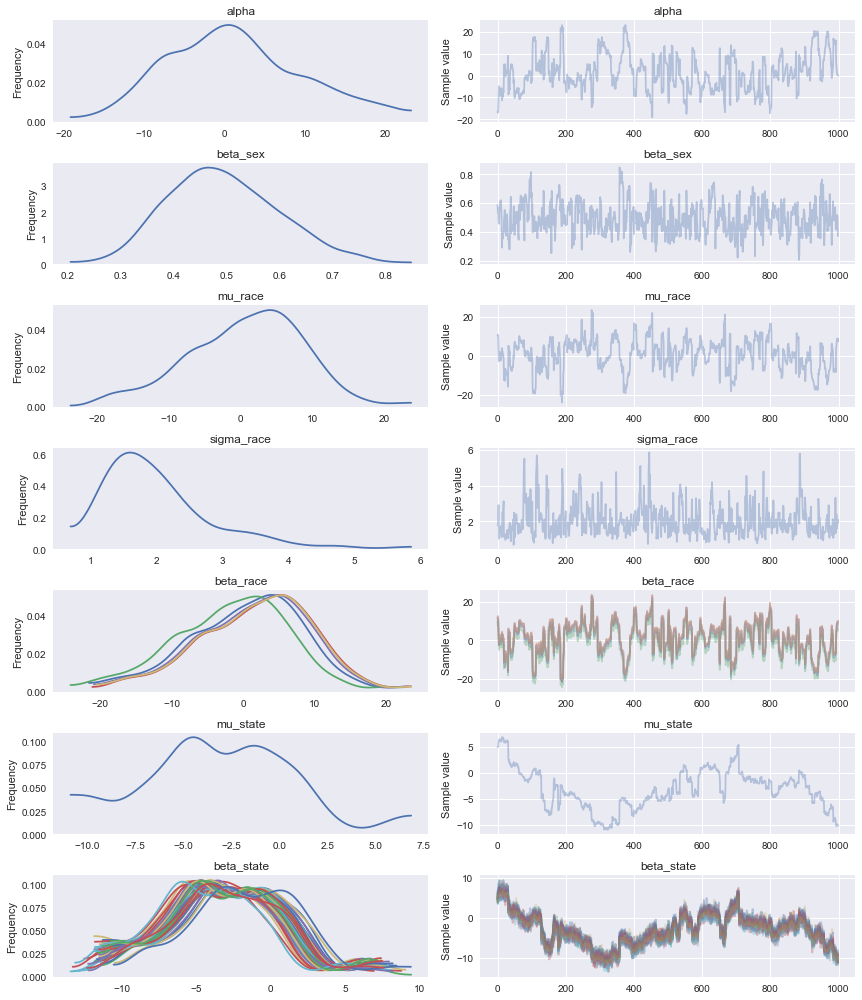

In [31]:
pm.traceplot(trace_complete, varnames_model_complete)

The plot below shows the 95% credible intervals for each parameter - i.e., the range of values that is required to capture the middle 95% of the sample values. The darker lines in the middle show the interquartile range and the dot shows the mean. (While these might _sound_ something like 95% confidence intervals in null hypothesis significance testing, they're actually completely different: we have, here, 1000 samples, each of which has a plausible combination of values for all 57 parameters. We can use this full set of data to get an idea of how much each parameter varies by simply plotting the mean, interquartile range, and 95% credible interval, as we've done below.)

There's the most variability with the coefficients for race and state.

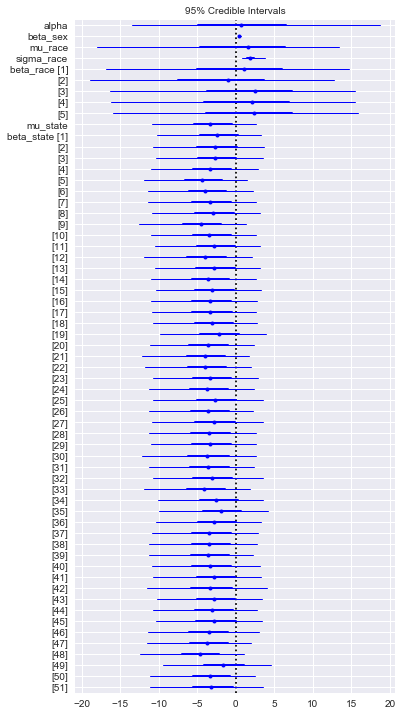

In [32]:
plt.figure(figsize=(6,11))
pm.forestplot(trace_complete, varnames_model_complete)

I also calculated the probabilities for each of the 510 cells at each of the 1000 steps in the chain, so I could get an idea of how much the probability (of voting for Trump) varies. The plot below has an x axis range from 0 to 1 - the closer the plot is to zero, the more likely people in that cell are to vote for Clinton; the closer the probability is to 1, the more likely people are to vote for Trump.

While the graphic below takes up a lot of space, it's worth including because of the amount of information in the plot. The chart below is the only part of this paper, at least, that shows visually the degree to which the probabilities for the different cells vary compared to each other. It's interesting, for example, how much wider the credible intervals are for cells for which the poll provides relatively little information - compare the rows for many of the California cells, which are narrow, to the rows for a state like Montana.

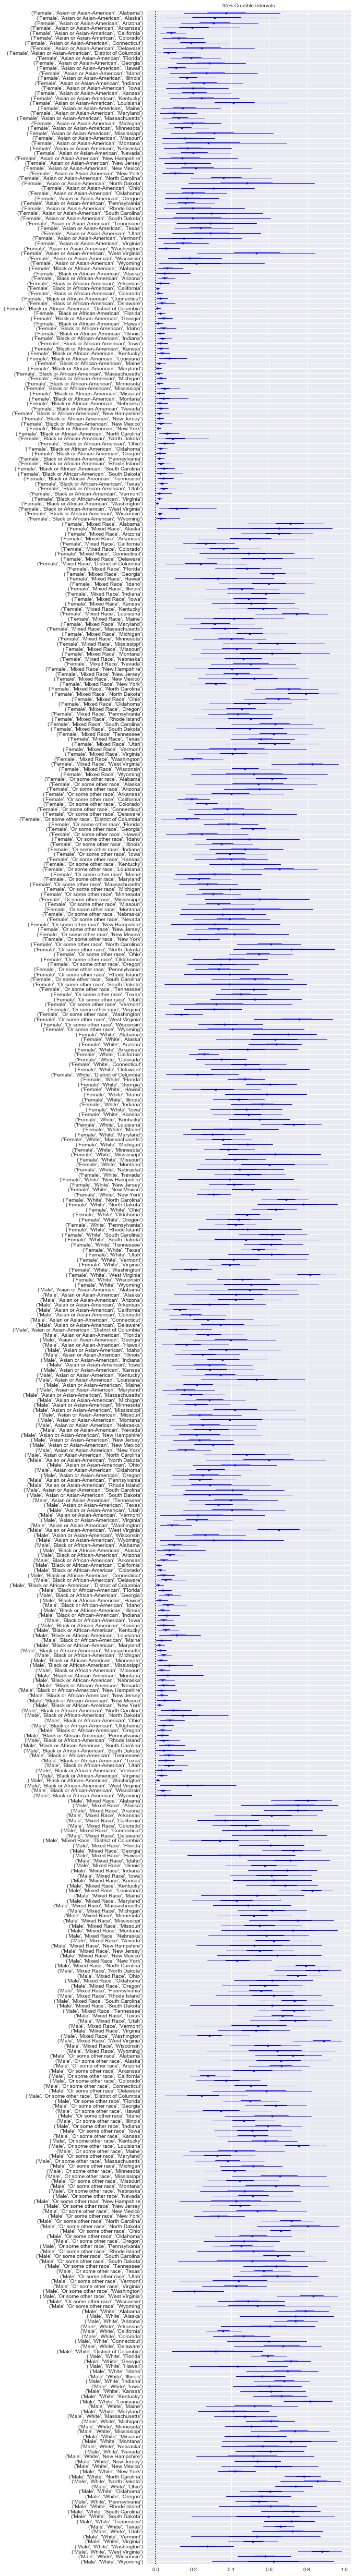

In [33]:
plt.figure(figsize=(6,80))
pm.forestplot(trace_complete, ['probs'], ylabels=all_cells_list)

Generally the less parameter values are correlated with the previous values (i.e., auto-correlated), the more efficient the sampling process. I won't lengthen this notebook with the results of the following diagnostic plot, and will just say that the parameters show relatively little auto-correlation. (This is the case at least with this particular random seed - with some other seeds the auto-correlation for state fields is worse; this doesn't appear to hurt the final results in ways that I can determine, but it is evidence that I might want more samples if I was to work with the data further.)

In [34]:
# pm.autocorrplot(trace_complete, varnames_model_complete)

Finally, here are the coefficient values and ranges, already shown above graphically, as numbers.

In [35]:
pm.df_summary(trace_complete, varnames_model_complete)

,mean,sd,mc_error,hpd_2.5,hpd_97.5
alpha,1.357316,8.415076,0.692283,-13.468916,18.765583
beta_sex,0.493401,0.106061,0.006668,0.306307,0.714707
mu_race,0.709894,7.973462,0.633234,-17.971127,13.373366
sigma_race,2.027836,0.852497,0.051838,0.808731,3.773675
beta_race__0,0.392370,7.986991,0.633719,-16.874933,14.757469
beta_race__1,-1.835387,7.981816,0.633481,-18.936520,12.794145
beta_race__2,1.818100,7.994847,0.635606,-16.272718,15.441299
beta_race__3,1.383405,7.983712,0.634418,-16.115869,15.524240
beta_race__4,1.759833,7.979918,0.633470,-15.886582,15.837880
mu_state,-3.130757,3.756508,0.367735,-10.843842,2.645228


## Calculate and add probabilities per cell

Ultimately, the point of the above model is to generate probabilities for each cell. I calculate the probabilities here, for each of the 510 cells, and then append the probabilities to the all_cells dataframe I'm using to keep track of each cell.

For the sake of simplicity, I calculate just a single probability for each cell, using the average/mean value of the coefficient (from all 1000 sample values). The data in the chain would make it easy to also show the uncertainty in the probability, but I'm not going to do that here for now, for the sake of simplicity.

In [36]:
def classify_with_matrix(values_matrix, trace_data, varnames, add_intercept=False):
    """
    Return the probability of the cell taking the value of 1 (in this code, this means the
    probability of voting for Trump).
    
    values_matrix: a matrix of values denoting the cell, as a set of indicator fields
    trace_data: MCMC chain of samples, from PyMC3
    varnames: variables in the chain, should be the same size as the width of values_matrix
    add_intercept: whether to add a column of 1s as the first column; useful when the trace has an alpha intercept.
    """
    if add_intercept:
        # add a column at the beginning with all ones, to match up w/ something like an alpha param
        values_matrix = np.c_[np.ones(len(values_matrix)), values_matrix]

    mean_vals = pm.df_summary(trace_data, varnames)['mean'].values

    # dot product matrix multiplication FTW, to get 510 probabilities in one fell swoop
    mu = np.dot(values_matrix, mean_vals)

    prob = standard_logistic(mu)
    return prob

In [37]:
probs = classify_with_matrix(all_cells_dummies, trace_complete,
                            ['alpha','beta_sex','beta_race','beta_state'], add_intercept=True)
probs.shape

(510,)

In [38]:
all_cells['trump_prob'] = probs
all_cells.shape

(510, 4)

In [39]:
all_cells[:2]

,sex,racecmb,state,trump_prob
0,Female,Asian or Asian-American,Alabama,0.373788
1,Female,Asian or Asian-American,Alaska,0.309324


I'll also keep the probability data from the chain itself, for comparison and as a way to show uncertainty. This uses the set of 510 parameters defined in the model with the name 'prob'.

In [40]:
all_cells_with_trace = pd.concat([all_cells, pm.df_summary(trace_complete, ['probs']).reset_index(drop=True)], axis=1)
all_cells_with_trace[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239


## Load and prepare CPS data for population calculations

So, I now have estimates for the probability of voting for Trump for each cell. The other data I need to post-stratify and generate an overall prediction is the population in each cell. It's this population that I'll use to weight/adjust the probabilities.

The population data is from the US Census and IPUMS at the University of Minnesota and is documented in more detail in the [README](README.md). This data, from the ASEC 2016 data set, contains a row per person surveyed, with the person's sex, race/ethnicity, and state. Each row also contains a weight column, called WTSUPP, that shows the degree to which that person's obvservation should be weighted so that the end result is representative of the US population.

In [41]:
d_pop = pd.read_csv('cps_population.csv')
d_pop.shape

(185487, 4)

In [42]:
d_pop[:2]

,RACE,WTSUPP,SEX,STATECENSUS
0,White,1132.05,Female,Maine
1,White,1077.54,Female,Maine


The values from the CPS need to match the values from the Pew poll data. I examined the sex and state values, and they're fine and need no work. For race/ethnicity, the CPS provides data at a much more granular level, so I'll map here to the five values used in the poll data.

In [43]:
map_cps_race_to_pew_racecmb = {
    'White':'White',
    'Black/Negro':'Black or African-American',
    'Asian only':'Asian or Asian-American',
    'American Indian/Aleut/Eskimo':'Or some other race',
    'White-American Indian':'Mixed Race',
    'White-Black':'Mixed Race',
    'Hawaiian/Pacific Islander only':'Or some other race',
    'White-Asian':'Mixed Race',
    'White-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian':'Mixed Race',
    'Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-Black-American Indian':'Mixed Race',
    'White-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-Asian':'Mixed Race',
    'White-Black-Asian':'Mixed Race',
    'Four or five races, unspecified':'Mixed Race',
    'Black-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian':'Mixed Race',
    'Two or three races, unspecified':'Mixed Race',
    'American Indian-Asian':'Mixed Race',
    'White-Black-American Indian-Asian':'Mixed Race',
    'White-Black--Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Asian-Hawaiian/Pacific Islander':'Mixed Race',
    'White-American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'American Indian-Hawaiian/Pacific Islander':'Mixed Race',
    'Black-American Indian-Asian':'Mixed Race'
}
map_cps_race_to_pew_racecmb

d_pop['mapped_racecmb'] = d_pop['RACE'].map(map_cps_race_to_pew_racecmb)

d_pop['mapped_racecmb'].value_counts(dropna=False)

White                        142972
Black or African-American     22872
Asian or Asian-American       10709
Mixed Race                     4690
Or some other race             4244
Name: mapped_racecmb, dtype: int64

## Calculate predicted votes based on preferences and cell populations

And now I'll augment the by-cell data first with the population for that cell, and then with the predicted number of Clinton and Trump votes.

The population for each cell is the sum of the WTSUPP values for every person with the characteristics of that cell. I'll first calculate the populations.

In [44]:
population_by_cell = d_pop.groupby(['SEX','mapped_racecmb','STATECENSUS'], as_index=False)['WTSUPP'].sum()
population_by_cell.shape

(510, 4)

And then merge the populations into the cell data, by joining on the combination of sex, race, and state.

In [45]:
all_cells_with_pop = all_cells_with_trace.merge(population_by_cell, 
                                                left_on=['sex','racecmb','state'], 
                                                right_on=['SEX','mapped_racecmb','STATECENSUS'],
                                                validate='1:1')#[['sex','racecmb','state','trump_prob','WTSUPP']]
all_cells_with_pop.drop(columns=['SEX','mapped_racecmb','STATECENSUS'], inplace=True)
all_cells_with_pop.rename(columns={'WTSUPP':'population'}, inplace=True)
all_cells_with_pop[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624,51040.97
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239,28853.07
2,Female,Asian or Asian-American,Arizona,0.309394,0.320101,0.112852,0.003613,0.131234,0.541077,124310.67


Using the probability of voting for Trump and the population from each cell, I'll add columns with calculated number of votes for Clinton and Trump.

I'll do this in a function so that I can reuse the same code below when I add vote counts from other models.

In [46]:
def add_vote_columns(df, population_col, prob_col, vote_col_prefix):
    """
    Add columns that contain the number of Clinton and Trump votes, to the passed data frame.
    
    df: dataframe with population and probability data, and to which the new columns are to be added\
    population_col: name of the column in df that holds the population
    prob_col: name of the column in df that holds the probability of voting for Trump
    vote_col_prefix: prefix to be added to the vote columns
    """
    df_new = df.copy()
    df_new[f"{vote_col_prefix}_clinton"] = np.round(df_new[population_col] * (1 - df_new[prob_col])).astype(int)
    df_new[f"{vote_col_prefix}_trump"] = np.round(df_new[population_col] * df_new[prob_col]).astype(int)

    return df_new

In [47]:
all_cells_with_results = add_vote_columns(all_cells_with_pop, 'population', 'trump_prob', 'votes')
all_cells_with_results[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624,51040.97,31962,19078
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239,28853.07,19928,8925
2,Female,Asian or Asian-American,Arizona,0.309394,0.320101,0.112852,0.003613,0.131234,0.541077,124310.67,85850,38461


## Calculate MRP prediction

Now I have everything I need - votes for Clinton and Trump, per cell - to calculate the final prediction with data from all cells. 

I'll define a function that calculates the totals and proportions, and that persists these results in a row that I'll add to a dataframe as I go along, building up a single results dataframe that summarizes my results across all of the models I'll try.

In [48]:
def get_counts_and_proportions(label, clinton_count, trump_count, verbose=True):
    """
    Return results for a single model as a dataframe row.
    
    label: index/label value for the row, should describe the model
    clinton_count: total votes for Clinton
    trump_count: total votes for Trump
    verbose: print results in addition to returning the row
    """
    all_rows_count = clinton_count + trump_count
    clinton_prop = clinton_count / all_rows_count
    trump_prop = trump_count / all_rows_count
    
    if verbose:
        print(f"Total  \t{all_rows_count:,}")
        print(f"Clinton\t{clinton_count:,} ({clinton_prop:.1%})")
        print(f"Trump  \t{trump_count:,} ({trump_prop:.1%})")
    
    return pd.DataFrame.from_records(data=[(clinton_count, clinton_prop, trump_count, trump_prop, all_rows_count)], 
                                     index=[label],
                                     columns=['Clinton count','Clinton proportion','Trump count','Trump proportion','Total count'])

And then I'll start my results dataframe using the model I've built up to this point.

In [49]:
result_comparison = get_counts_and_proportions("Bayesian MRP", 
                                               all_cells_with_results['votes_clinton'].sum(),
                                               all_cells_with_results['votes_trump'].sum())

result_comparison

Total  	318,868,506
Clinton	180,771,982 (56.7%)
Trump  	138,096,524 (43.3%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180771982,0.566917,138096524,0.433083,318868506


## Calculate prediction from poll using poll weights

The poll data itself contains weighting information - this information, a result of sophisticated weighting performed by the good people at Pew - could be used to make the poll data representative of people likely to vote. The Bayesian MRP model above completely ignores the weighting information that comes with the poll data itself... that is, it uses the raw poll data and doesn't up front weight the data. Put differently, without using the weighting data, the poll data is unrepresentative.

Ideally the prediction I get from my Bayesian MRP model, based on just the unrepresentative data from the poll, would be close to the prediction baeed on Pew's weighting. To compare, then, this section calculates the poll's predictions - once after weighting and once without weighting - and adds these predictions to the results dataframe.

In [50]:
d_only.groupby(['q10horseGP'])['weight'].sum()

q10horseGP
Clinton/lean Clinton    2628.352941
Trump/lean Trump        2276.147059
Name: weight, dtype: float64

In [51]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Pew Research, weighted",
    round(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']['weight'].sum()),
    round(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']['weight'].sum()))])

Total  	4,904.0
Clinton	2,628.0 (53.6%)
Trump  	2,276.0 (46.4%)


And if we don't use the weights?

In [52]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Pew Research, unweighted",
    len(d_only[d_only['q10horseGP'] == 'Clinton/lean Clinton']),
    len(d_only[d_only['q10horseGP'] == 'Trump/lean Trump']))])

result_comparison

Total  	1,830
Clinton	972 (53.1%)
Trump  	858 (46.9%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180771982.0,0.566917,138096524.0,0.433083,318868506.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0


## Does adjusting for likelihood to vote change the MRP predictions?

There are a lot of ways I can improve the model I've already defined and hopefully improve its prediction; I'll discuss many of these options below in the Discussion section. 

I did want to try one particular potential improvement that tries to answer a primary concern: does the fact that I'm not considering whether a person is actually going to vote hurt my results? For example, I don't want to include, say, a heavy contribution from a cell that's heavily pro-Clinton or pro-Trump, IF the people in that cell aren't likely to vote.

As a first cut at estimating the degree to which people in different cells vote, I'll use an additional CPS data set from the US Census and IPUMS at the University of Minnesota. Like with the previous data sets, this data is documented in more detail in the [README](README.md). The vote data, from the November 2016 monthly data set, contains a row per person surveyed, with the person's sex, race/ethnicity, state, and whether the person voted in the most recent election - this voted data is only available in the "monthly" data sets, and is not in the ASEC 2016 data set I used previously. Each row also contains a weight column, now called WTFINL, that shows the degree to which that person's observation should be weighted so that the end result is representative of the US population. 

(This data is similar to but not the same as the CPS population data used previously - they come from different IPUMS/CPS samples. As described in the README, the vote data comes from the November 2016 "monthly" data set and the population data comes from the ASEC 2016 data set. I think I could potentially get all of the data I need for both population and voting behavior from the monthly data, but I only first pulled the monthly data to get the voted data and didn't want to spend the time to go back and change and verify the population calculations, at least for now.)

In [53]:
d_voting = pd.read_csv('cps_votes.csv')
d_voting.shape

(131389, 5)

In [54]:
d_voting[:2]

,RACE,WTFINL,SEX,STATEFIP,VOTED
0,White,1878.9962,Male,Alabama,Voted
1,White,1519.4506,Female,Alabama,Did not vote


I need to remap the CPS race/ethnicity values to match the Pew values.

In [55]:
d_voting['mapped_racecmb'] = d_voting['RACE'].map(map_cps_race_to_pew_racecmb)
d_voting['mapped_racecmb'].value_counts(dropna=False)

White                        104857
Black or African-American     14055
Asian or Asian-American        6972
Mixed Race                     2901
Or some other race             2604
Name: mapped_racecmb, dtype: int64

We have 510 cells, and we should have 510 counts of voters. Do we?

In [56]:
d_voting_pop_by_cell = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP'], as_index=False)['WTFINL'].sum()
d_voting_pop_by_cell.shape

(508, 4)

Hmm... nope - we have 508 when we should have 510. 

Which states don't have all one row for each cell?

In [57]:
(d_voting_pop_by_cell['STATEFIP'].unique())[d_voting_pop_by_cell.groupby('STATEFIP').size() < 10]

array(['Maine', 'Vermont'], dtype=object)

In [58]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Maine']

,SEX,mapped_racecmb,STATEFIP,WTFINL
19,Female,Asian or Asian-American,Maine,9754.6069
70,Female,Black or African-American,Maine,4462.1727
121,Female,Mixed Race,Maine,13686.0606
222,Female,White,Maine,644054.1601
273,Male,Asian or Asian-American,Maine,5334.7327
324,Male,Black or African-American,Maine,14303.7411
375,Male,Mixed Race,Maine,20999.6773
426,Male,Or some other race,Maine,5108.2904
476,Male,White,Maine,598546.5575


In [59]:
d_voting_pop_by_cell[d_voting_pop_by_cell['STATEFIP'] == 'Vermont']

,SEX,mapped_racecmb,STATEFIP,WTFINL
45,Female,Asian or Asian-American,Vermont,7194.2980
96,Female,Black or African-American,Vermont,3659.6508
147,Female,Mixed Race,Vermont,7383.7707
197,Female,Or some other race,Vermont,3078.2986
248,Female,White,Vermont,292484.9831
299,Male,Asian or Asian-American,Vermont,8141.2312
350,Male,Black or African-American,Vermont,4593.6401
401,Male,Mixed Race,Vermont,8969.2326
502,Male,White,Vermont,283089.8951


Turns out that Maine is missing females of 'Or some other race' and Vermont is missing males of 'Or some other race'. I'll handle this in the function below that calculates the proportion that voted.

In [64]:
d_voted_pop_by_cell = None
d_didnotvote_pop_by_cell = None

In [65]:
def get_voted_proportion(g):
    """
    Return the proportion that voted for the passed group, handling cases where there are no
    voted and/or not voted rows; meant to be called from a groupby.
    """
    voted_count = g[g['VOTED'] == 'Voted']['WTFINL'].sum()
    if np.isnan(voted_count): # if there are no vote rows, then we had zero (don't think there's a way to do this via a built-in function)
        voted_count = 0
    
    didnotvote_count = g[g['VOTED'] == 'Did not vote']['WTFINL'].sum()
    if np.isnan(didnotvote_count): 
        didnotvote_count = 0

    total_count = voted_count + didnotvote_count
    
    # we can only return a proportino when we have at least some rows; otherwise we return NaN
    if total_count != 0:
        return voted_count / (voted_count + didnotvote_count)
    else:
        return np.nan

Now, using the above function, calculate the proportion that voted for each cell, and then add this proportion to the cell data.

In [66]:
# have to use reset_index instead of as_index=False because the latter isn't working w/ .apply
d_voted_prop = d_voting.groupby(['SEX','mapped_racecmb','STATEFIP']).apply(get_voted_proportion).reset_index()
d_voted_prop.rename(columns={0:'voted_prop','SEX':'sex','mapped_racecmb':'racecmb','STATEFIP':'state'}, inplace=True)
d_voted_prop[:5]

,sex,racecmb,state,voted_prop
0,Female,Asian or Asian-American,Alabama,0.365283
1,Female,Asian or Asian-American,Alaska,0.594235
2,Female,Asian or Asian-American,Arizona,0.721009
3,Female,Asian or Asian-American,Arkansas,1.000000
4,Female,Asian or Asian-American,California,0.617409


In [67]:
all_cells_with_results_and_voted_prop = all_cells_with_results.merge(d_voted_prop, 
                on=['sex','racecmb','state'], how='left')
all_cells_with_results_and_voted_prop.shape

(510, 13)

In [68]:
all_cells_with_results_and_voted_prop[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624,51040.97,31962,19078,0.365283
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239,28853.07,19928,8925,0.594235


### Impute/guess at some proportions where we don't have data

The November 2016 monthly CPS data doesn't have voted data for every single one of the 510 cells. For two - noted above - there's no data at all/no rows at all for a particular combination, and for more than thwo there are at least some rows but there are rows where the values were 'voted' or 'did not vote'. In either case, we have a NaN, since we can't say anything at all about that cell. (There are also some cells where all of the rows are either vote or did not vote, and we've - for better or worse - already marked these as 100% or 0%, respectively.)

For ease of implementation, I'll start by just setting these values to the average voted proportion (overall - I could do it from common cells, but won't bother since the number of affected votes is small).

In [69]:
voted_count = d_voting[d_voting['VOTED'] == 'Voted']['WTFINL'].sum()
did_not_vote_count = d_voting[d_voting['VOTED'] == 'Did not vote']['WTFINL'].sum()
overall_prop_voted = voted_count / (voted_count + did_not_vote_count)
overall_prop_voted

0.71859397336959685

In [70]:
all_cells_with_results_and_voted_prop['voted_prop'].fillna(overall_prop_voted, inplace=True)

In [71]:
all_cells_with_results_and_voted_prop[all_cells_with_results_and_voted_prop['voted_prop'].isnull()]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop


### Add counts for population that votes, and for Clinton and Trump

And now I can calculate first a new 'population' count for each cell, by multiplying the overall population by an estimate of the proportion that vote, and then split up this new count into Clinton and Trump votes. 

In [72]:
all_cells_with_results_and_adj_voted_data = all_cells_with_results_and_voted_prop.copy()
all_cells_with_results_and_adj_voted_data['est_population_voted'] = all_cells_with_results_and_adj_voted_data['population'] * \
                                                            all_cells_with_results_and_adj_voted_data['voted_prop']
all_cells_with_results_and_adj_voted_data = add_vote_columns(all_cells_with_results_and_adj_voted_data, 
                                                             'est_population_voted', 'trump_prob', 'votes_adj')

all_cells_with_results_and_adj_voted_data[:3]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624,51040.97,31962,19078,0.365283,18644.420075,11675,6969
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239,28853.07,19928,8925,0.594235,17145.491035,11842,5304
2,Female,Asian or Asian-American,Arizona,0.309394,0.320101,0.112852,0.003613,0.131234,0.541077,124310.67,85850,38461,0.721009,89629.100394,61898,27731


### Add the prediction based on counts adjusted for likelihood to vote

And then add the results using the likelihood of voting.

In [73]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Bayesian MRP (adjusted for likelihood of voting)",
    all_cells_with_results_and_adj_voted_data['votes_adj_clinton'].sum(),
    all_cells_with_results_and_adj_voted_data['votes_adj_trump'].sum())])

result_comparison

Total  	227,710,322
Clinton	129,233,808 (56.8%)
Trump  	98,476,514 (43.2%)


,Clinton count,Clinton proportion,Trump count,Trump proportion,Total count
Bayesian MRP,180771982.0,0.566917,138096524.0,0.433083,318868506.0
"Pew Research, weighted",2628.0,0.535889,2276.0,0.464111,4904.0
"Pew Research, unweighted",972.0,0.531148,858.0,0.468852,1830.0
Bayesian MRP (adjusted for likelihood of voting),129233808.0,0.567536,98476514.0,0.432464,227710322.0


This proportion is dismayingly close to the original prediction - here 0.5685 vs 0.5678, even though the number of votes is much smaller and, from a quick review, there are cells that have different proportions of people that voted and could affect the overall numbers. 

However, this is evidence that the difference between my original prediction and the Pew prediction isn't solely the fact that I originally did not account for likelihood to vote.

Also, some or all of the difference could be that I should adjust for the likelihood to vote in some other fashion. For example, the Xbox paper introduced above appears to adjust for likelihood to vote by creating an additional Bayesian model to predict whether someone will vote for one of the two primary candidates, and then feeds the output of this model into another model that estimates the proportion voting for one candidate or the other. 

## What's the prediction if we use a simple logistic regression for the proportions?

The first part of post-stratification generally is estimating the proportion for each cell. Above I've done this with a Bayesian multi-level regression model. While not complicated, as far as Bayesian inference models go, it's certainly more complicated than something like an ordinary least squares logistic regression model, and certainly takes a _lot_ more computing power to produce. 

For the sake of comparison, what kind of performance do I get if I do just use a simple OLS logistic regression model?

I can do this using the same set of y_obs results and the d_only_dummies dataframe of indicator variables, and Scikit-Learn.

In [74]:
lr = LogisticRegression().fit(d_only_dummies.values, y_obs)

And then calculate and the proportions and calculated vote counts based on this model to the set of all cells data.

In [75]:
all_cells_with_results_and_adj_voted_data_and_lr_prob = all_cells_with_results_and_adj_voted_data.copy()

# calculate estimated proportion, again using matrix multiplication to do it one line and quickly
all_cells_with_results_and_adj_voted_data_and_lr_prob['lr_prob'] = \
    standard_logistic(all_cells_dummies.dot(lr.coef_.T) + lr.intercept_)
    
all_cells_with_results_and_adj_voted_data_and_lr = add_vote_columns(all_cells_with_results_and_adj_voted_data_and_lr_prob, 
                                                                    'population', 'lr_prob', 'lr_votes')
    
all_cells_with_results_and_adj_voted_data_and_lr.shape

(510, 19)

In [76]:
all_cells_with_results_and_adj_voted_data_and_lr[:2]

,sex,racecmb,state,trump_prob,mean,sd,mc_error,hpd_2.5,hpd_97.5,population,votes_clinton,votes_trump,voted_prop,est_population_voted,votes_adj_clinton,votes_adj_trump,lr_prob,lr_votes_clinton,lr_votes_trump
0,Female,Asian or Asian-American,Alabama,0.373788,0.383418,0.135380,0.003846,0.149931,0.657624,51040.97,31962,19078,0.365283,18644.420075,11675,6969,0.392024,31032,20009
1,Female,Asian or Asian-American,Alaska,0.309324,0.333282,0.171006,0.005632,0.055927,0.647239,28853.07,19928,8925,0.594235,17145.491035,11842,5304,0.331487,19289,9564


And update the results dataframe with the overall prediction based on the logistic regression model. 

In [77]:
result_comparison = pd.concat([result_comparison, get_counts_and_proportions("Logistic regression (OLS)",
    all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_clinton'].sum(),
    all_cells_with_results_and_adj_voted_data_and_lr['lr_votes_trump'].sum())])

Total  	318,868,497
Clinton	180,278,277 (56.5%)
Trump  	138,590,220 (43.5%)


# Findings

First off, I'm curious if the probabilities estimated by the Bayesian multi-level logistic regression model pass the sniff test... do they make sense?

To check this, I'll get a table that shows all probabilities, by state and sex/race, and then draw it as a heatmap. I'll also shorten a few of the longer state names so they're more legible when rotated.

In [78]:
trump_probs_by_sex_and_race = all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob').T
trump_probs_by_sex_and_race.rename(columns={'District of Columbia':'D.C.',
                                            'Massachusetts':'Mass.',
                                            'New Hampshire':'New Hamp.',
                                            'North Carolina':'N. Carolina',
                                            'South Carolina':'S. Carolina',
                                            'North Dakota':'N. Dakota'}, inplace=True)
trump_probs_by_sex_and_race

state                              Alabama    Alaska   Arizona  Arkansas  \
sex    racecmb                                                             
Female Asian or Asian-American    0.373788  0.309324  0.309394  0.192629   
       Black or African-American  0.060440  0.046043  0.046058  0.025068   
       Mixed Race                 0.712945  0.650776  0.650850  0.498178   
       Or some other race         0.616574  0.546801  0.546882  0.391269   
       White                      0.700874  0.637420  0.637495  0.483617   
Male   Asian or Asian-American    0.494350  0.423144  0.423224  0.280978   
       Black or African-American  0.095319  0.073262  0.073284  0.040412   
       Mixed Race                 0.802680  0.753218  0.753279  0.619190   
       Or some other race         0.724807  0.663997  0.664069  0.512852   
       White                      0.793288  0.742229  0.742291  0.605359   

state                             California  Colorado  Connecticut  Delaware  \
sex    racecmb                                                                  
Female Asian or Asian-American      0.079542  0.119125     0.187219  0.241859   
       Black or African-American    0.009227  0.014365     0.024223  0.033238   
       Mixed Race                   0.264470  0.360080     0.489389  0.570334   
       Or some other race           0.188841  0.267037     0.382926  0.462202   
       White                        0.253292  0.346767     0.474842  0.556001   
Male   Asian or Asian-American      0.123988  0.181333     0.273929  0.343189   
       Black or African-American    0.015024  0.023314     0.039070  0.053309   
       Mixed Race                   0.370643  0.479608     0.610865  0.684950   
       Or some other race           0.276047  0.373716     0.504064  0.584657   
       White                        0.357156  0.465087     0.596928  0.672244   

state                                 D.C.   Florida    ...     South Dakota  \
sex    racecmb                                          ...                    
Female Asian or Asian-American    0.066996  0.185874    ...         0.190333   
       Black or African-American  0.007679  0.024014    ...         0.024708   
       Mixed Race                 0.230047  0.487174    ...         0.494471   
       Or some other race         0.162092  0.380834    ...         0.387742   
       White                      0.219889  0.472632    ...         0.479915   
Male   Asian or Asian-American    0.105234  0.272170    ...         0.277992   
       Black or African-American  0.012516  0.038739    ...         0.039841   
       Mixed Race                 0.328573  0.608756    ...         0.615687   
       Or some other race         0.240609  0.501848    ...         0.509146   
       White                      0.315849  0.594794    ...         0.601811   

state                             Tennessee     Texas      Utah   Vermont  \
sex    racecmb                                                              
Female Asian or Asian-American     0.287398  0.232888  0.290188  0.151689   
       Black or African-American   0.041654  0.031681  0.042200  0.018906   
       Mixed Race                  0.626604  0.558150  0.629776  0.426613   
       Or some other race          0.520733  0.449909  0.524122  0.325112   
       White                       0.612874  0.543735  0.616091  0.412425   
Male   Asian or Asian-American     0.397797  0.332107  0.401055  0.226530   
       Black or African-American   0.066458  0.050862  0.067306  0.030597   
       Mixed Race                  0.733231  0.674159  0.735879  0.549269   
       Or some other race          0.640234  0.572574  0.643357  0.441031   
       White                       0.721680  0.661232  0.724400  0.534806   

state                             Virginia  Washington  West Virginia  \
sex    racecmb                                                          
Female Asian or Asian-American    0.142512    0.054268       0.540073   
       Bl

And here's the data as a horizontally-oriented heat map. 

At least visually, it does look like the model generates probabilities that make sense. For example, relatively liberal coastal states tend Clinton while states in the interior and in the South, at least, prefer Trump at higher rates. Males prefer Trump more than females, and there are significant differences by race/ethnicity.

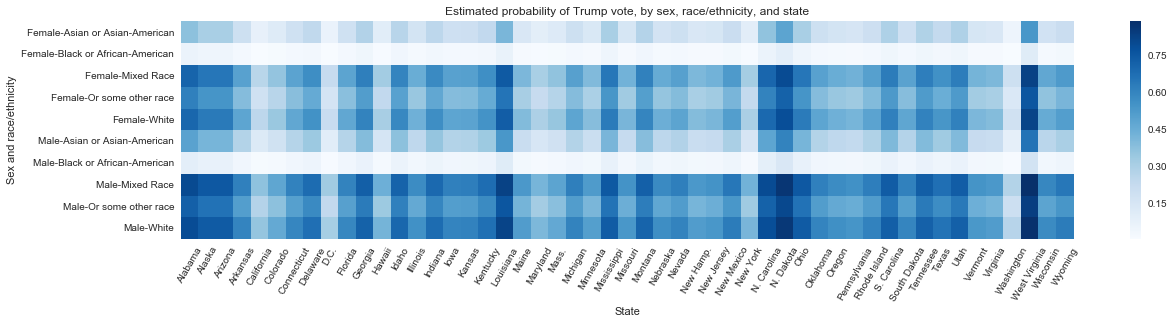

In [79]:
plt.figure(figsize=(20,4))
ax = sns.heatmap(trump_probs_by_sex_and_race, cmap='Blues')

ax.set_title('Estimated probability of Trump vote, by sex, race/ethnicity, and state')
ax.set_xlabel('State')
ax.set_ylabel('Sex and race/ethnicity')

# rotate state labels so they're at least a bit easier to read
for tick in ax.get_xticklabels():
    tick.set_rotation(60)

I also want a vertically-oriented heatmap that I can more easily use in a presentation, and I'll generate that here. For this one I'll shorten some of the race/ethnicity values so they fit better.

In [80]:
shorten_racecmb_values = {'Asian or Asian-American':'Asian',
                          'Black or African-American':'Black',
                          'Mixed Race':'Mixed',
                          'Or some other race':'Other',
                          'White':'White'}

In [81]:
trump_probs_by_state = all_cells.pivot_table(columns=['sex','racecmb'],index='state',values='trump_prob')
# shorten racecmb labels for display, hack per https://stackoverflow.com/questions/32892751/set-level-values-in-multiindex
trump_probs_by_state.columns = trump_probs_by_state.columns.set_levels(trump_probs_by_state.columns.levels[1].map(shorten_racecmb_values.get), "racecmb")
trump_probs_by_state.columns = [', '.join(col).strip() for col in trump_probs_by_state.columns.values]

trump_probs_by_state[:3]

,"Female, Asian","Female, Black","Female, Mixed","Female, Other","Female, White","Male, Asian","Male, Black","Male, Mixed","Male, Other","Male, White"
state,,,,,,,,,,
Alabama,0.373788,0.060440,0.712945,0.616574,0.700874,0.494350,0.095319,0.802680,0.724807,0.793288
Alaska,0.309324,0.046043,0.650776,0.546801,0.637420,0.423144,0.073262,0.753218,0.663997,0.742229
Arizona,0.309394,0.046058,0.650850,0.546882,0.637495,0.423224,0.073284,0.753279,0.664069,0.742291


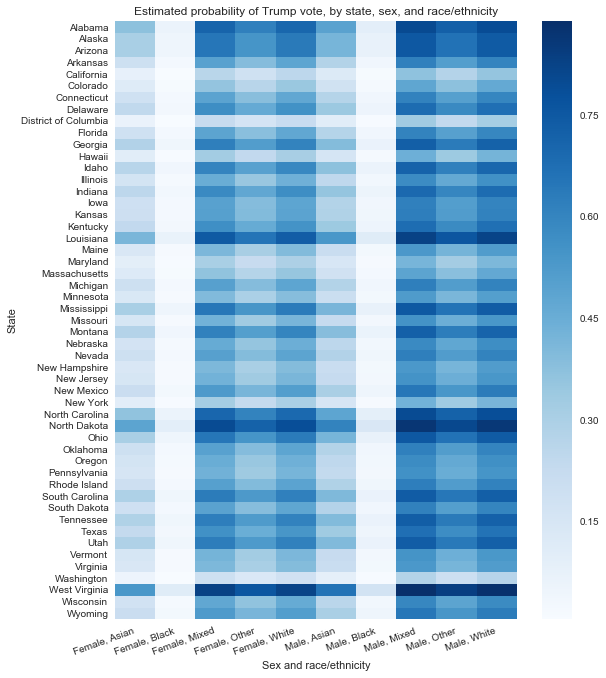

In [82]:
plt.figure(figsize=(9,11))
ax = sns.heatmap(trump_probs_by_state, cmap='Blues')

ax.set_title('Estimated probability of Trump vote, by state, sex, and race/ethnicity')
ax.set_ylabel('State')
ax.set_xlabel('Sex and race/ethnicity')

# rotate and shift x axis labels by a bit for aesthetic reasons
for i, tick in enumerate(ax.get_xticklabels()):
    tick.set_rotation(20)
    tick.set_ha('right')

I also want to view, all up, the results per model, and compare the performance to the weighting that's a part of the Pew poll.

In [83]:
result_comparison[['Clinton proportion','Trump proportion']].applymap('{:.1%}'.format)

,Clinton proportion,Trump proportion
Bayesian MRP,56.7%,43.3%
"Pew Research, weighted",53.6%,46.4%
"Pew Research, unweighted",53.1%,46.9%
Bayesian MRP (adjusted for likelihood of voting),56.8%,43.2%
Logistic regression (OLS),56.5%,43.5%


Ideally, the estimate I calculated using one of the Bayesian MRP models would be close to the estimate from the Pew poll. This isn't the case: all of the models I tried provide estimates that have Clinton favored by about an additional three percentage points over the Pew poll. My first guess at why this is happening is that I'm simply not stratifying on enough of the important variables to correctly adjust the unrepresentative sample. Based on the documentation provided with the Pew data, the Pew results are weighted by eight separate features: "sex, age, education, race, Hispanic origin, region (U.S. Census definitions), population density, and telephone usage". Of these I only stratify based on two - sex and race. 

It's also interesting that the estimates from the very simple OLS logistic regression model are so close to the estimates from the Bayesian models. One of the benefits of a Bayesian hierarchical model is that it shares data between similar features, and this can be especially useful in cases where there is a little or no data for particular features. This property is known as 'shrinkage' because it shrinks estimates toward the value common across the data. I would have expected that this would be helpful in this case because the poll data is minimal, for example, for many states. However, the difference in the Clinton and Trump proportions are small enough, and close enough to a coin flip of 50%, that the shrinkage isn't easy to see. (It's not that shrinkage isn't working entirely - in the [ProjectResearch](ProjectResearch.ipynb) notebook I tested some artifical data with 1/3 and 2/3 proportions and reliably saw shrinkage for cells with little data to the 1/3 and 2/3 values.) 

## Save generated raw results/data

And I'll output the detailed per-cell data to a file for easier possible future use.

In [84]:
all_cells_with_results_and_adj_voted_data_and_lr.to_csv('mrp_cells.csv')

# Discussion

Based at least on what I've found in this project, post-stratifying an unrepresentative sample using a Bayesian multi-level regression model shows promise and should be possible, but it's not something that I at least was able to do in a relatively short time. Nonetheless, this notebook and the code in this repository at least provide a full example - from data to results - that shows how to use MRP with election data, and does so using "full" Bayesian inference with MCMC (as opposed to a simpler approach that, for example, just provides maximum likelihood estimates).

There are a number of things that could be done to learn more:

- As noted previously, I'd like to see if using additional fields improves the performance. The data from the ASEC 2016 data set includes many fields that could help, including age, 'density' (population density of the state), region (Census region), income, and highest level of school/highest degree. 
- Right now the handling of the propensity to vote and of voters with preferences besides Clinton and Trump might be insufficient. For example, the Xbox paper describes using two models: one that predicts whether a person is going to vote for the main candidates and then one that predicts the preference for those voters.
- The full Bayesian approach provides a lot of additional data on the variability/uncertainty in things like probabilities. For example, it shows that the uncertainty can vary substantially by cell. It would be interesting to try to incorporate estimates of variability into the results.
- The diagnostics for my MCMC sample could probably be better. For example, the mixing for many of the parameters isn't great. Can I fix this via changing the model? To what degree, really, is this a problem in this specific case?

# References

Project references:
- [README](README.md).
- [ProjectResearch](ProjectResearch.ipynb) notebook.

External references:
- [Bayesian Analysis with Python](https://www.amazon.com/Bayesian-Analysis-Python-Osvaldo-Martin/dp/1785883801/ref=tmm_pap_swatch_0?_encoding=UTF8&qid=1512752450&sr=8-1); Martin.
- [Deep Interactions with MRP: Election Turnout and Voting Patterns Among Small Electoral Subgroups](http://www.stat.columbia.edu/~gelman/research/published/misterp.pdf); Ghitza, Gelman.
- [Doing Bayesian Data Analysis, Second Edition: A Tutorial with R, JAGS, and Stan](https://www.amazon.com/Doing-Bayesian-Data-Analysis-Second/dp/0124058884/ref=sr_1_1?ie=UTF8&qid=1512752434&sr=8-1&keywords=kruschke); Kruschke. 
- [Estimating State Public Opinion With Multi-Level Regression and Poststratification using R](http://www.princeton.edu/~jkastell/MRP_primer/mrp_primer.pdf); Kastellec, Lax, Phillips.
- [Forecasting elections with non-representative polls](http://www.stat.columbia.edu/~gelman/research/published/forecasting-with-nonrepresentative-polls.pdf); Wang, Rothschild, Goel, Gelman.
- [How One 19-Year-Old Illinois Man Is Distorting National Polling Averages](https://www.nytimes.com/2016/10/13/upshot/how-one-19-year-old-illinois-man-is-distorting-national-polling-averages.html); Cohn.
- [Mister P can solve problems with survey weighting](http://andrewgelman.com/2016/10/12/31398/); Gelman.
- [Mister P: What’s its secret sauce?](http://andrewgelman.com/2013/10/09/mister-p-whats-its-secret-sauce/); Gelman.
- [Post-stratification](https://onlinecourses.science.psu.edu/stat506/node/29); Wikipedia.
- [Propensity score matching](https://en.wikipedia.org/wiki/Propensity_score_matching); Wikipedia.
- [PyMC3](https://github.com/pymc-devs/pymc3).
- [Statistical Rethinking: A Bayesian Course with Examples in R and Stan](https://www.amazon.com/Statistical-Rethinking-Bayesian-Examples-Chapman/dp/1482253445/ref=sr_1_1?ie=UTF8&qid=1512752416&sr=8-1&keywords=richard+mcelreath); McElreath.
- [We Gave Four Good Pollsters the Same Raw Data. They Had Four Different Results](https://www.nytimes.com/interactive/2016/09/20/upshot/the-error-the-polling-world-rarely-talks-about.html); Cohn.

NOTE: Ideally I'd use Markdown reference-style links, as described in the [Daring Fireball Markdown docs](https://daringfireball.net/projects/markdown/syntax#link), but it looks like they're not supported by Jupyter Notebook at least, so I'll just use inline-style links in the body of the notebook and here.